## Others: Conservative Q-Learning(CQL) Offline Reinforcement Learning (ORL)

从一份良好的数据集中学习，训练过程中完全不更新数据

In [1]:
import torch

# 封装数据集
class Dataset(torch.utils.data.Dataset):
  
  def __init__(self):
    import numpy as np
    data = np.loadtxt('orl.txt')
    self.state = torch.FloatTensor(data[:, :3]).reshape(-1, 3)
    self.action = torch.FloatTensor(data[:, 3]).reshape(-1, 1)
    self.reward = torch.FloatTensor(data[:, 4]).reshape(-1, 1)
    self.next_state = torch.FloatTensor(data[:, 5:8]).reshape(-1, 3)
    self.over = torch.LongTensor(data[:, 8]).reshape(-1, 1)
    
  def __len__(self):
    return len(self.state)
  
  def __getitem__(self, i):
    return self.state[i], self.action[i], self.reward[i], self.next_state[i], self.over[i]
  
dataset = Dataset()
len(dataset), dataset[0]

(20000,
 (tensor([0.9019, 0.4320, 0.8704]),
  tensor([-1.5736]),
  tensor([0.9651]),
  tensor([0.8817, 0.4719, 0.8943]),
  tensor([0])))

In [2]:
# 数据加载器
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=64, shuffle=True, drop_last=True)
len(loader)

312

In [3]:
# 定义模型
import torch
from sac import SAC

# 定义CQL算法，基于SAC
class CQL(SAC):
  
  def get_loss_cql(self, state, next_state, value):
    # state, next_state复制5遍
    state = state.unsqueeze(dim=1).repeat(1, 5, 1).reshape(-1, 3)
    next_state = next_state.unsqueeze(dim=1).repeat(1, 5, 1).reshape(-1, 3)
    
    # 计算动作和熵
    rand_action = torch.empty([len(state), 1]).uniform_(-1, 1)
    curr_action, _ = self.get_action_entropy(state)
    next_action, _ = self.get_action_entropy(next_state)
    
    # 计算三份动作分别的value
    value_rand = self.model_value(torch.cat([state, rand_action], dim=1))
    value_curr = self.model_value(torch.cat([state, curr_action], dim=1))
    value_next = self.model_value(torch.cat([state, next_action], dim=1))
    
    # 拼合三份value
    value_cat = torch.cat([value_rand, value_curr, value_next], dim=1)
    loss_cat = value_cat.exp().sum(dim=1) + 1e-8
    loss_cat = loss_cat.log().mean()
    
    # value loss 上增加这一部分
    return 5.0 * (loss_cat - value.mean())
  
cql = CQL()
cql

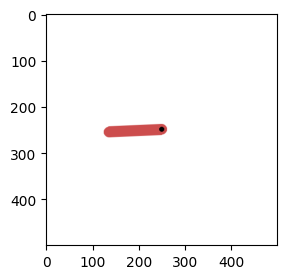

In [4]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  
  def __init__(self):
    env = gym.make('Pendulum-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
    
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
  
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step([action * 2])
    over = terminated or truncated

    # 偏移reward, 便于训练
    reward = (reward + 8) / 8
    
    #限制最大步数
    self.step_n += 1
    if self.step_n >= 200:
      over = True

    return state, reward, over
  
  # 打印游戏图像
  def show(self):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(3, 3))
    plt.imshow(self.env.render())
    plt.show()
    
env = MyWrapper()

env.reset()

env.show()

In [5]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
  data = []
  reward_sum = 0

  state = env.reset()
  over = False
  while not over:
    # 根据概率采样
    mu, sigma = cql.model_action(torch.FloatTensor(state).reshape(1, 3))
    action = random.normalvariate(mu=mu.item(), sigma=sigma.item())
    
    next_state, reward, over = env.step(action)

    data.append((state, action, reward, next_state, over))  
    reward_sum += reward

    state = next_state
    
    if show:
      display.clear_output(wait=True)
      env.show()

  return data, reward_sum

play()[-1]

38.40060412882414

In [6]:
# 训练
def train():
  for epoch in range(200):
    for i, (state, action, reward, next_state, over) in enumerate(loader):
      cql.train_value(state, action, reward, next_state, over)
      cql.train_action(state)
      
    if epoch % 10 == 0:
      value = cql.model_value(torch.cat([state, action], dim=1)).mean().item()
      test_result = sum([play()[-1] for _ in range(20)]) / 20
      print(epoch, value, test_result)
      
train()

0 2.3865725994110107 9.518834128799012
10 14.000141143798828 42.061501418896675
20 24.228418350219727 89.43097661046967
30 32.03629684448242 100.77587222037442
40 37.52537536621094 101.80207554853867
50 44.388275146484375 124.20214183267744
60 44.94777297973633 103.14727019574586
70 50.612422943115234 132.37568728925248
80 50.56443786621094 163.29962293887507
90 47.1673583984375 117.77889007392689
100 51.54493713378906 148.48324852309517
110 53.06547546386719 114.87067565329582
120 54.63275909423828 121.69721483357202
130 54.8488883972168 130.9613854381262
140 57.31464385986328 142.93313726072512
150 56.39596939086914 148.39912217398148
160 55.17572784423828 140.67733868161002
170 60.36277389526367 177.6654745020834
180 60.43495178222656 179.20849897969748
190 59.726402282714844 184.18955033231276


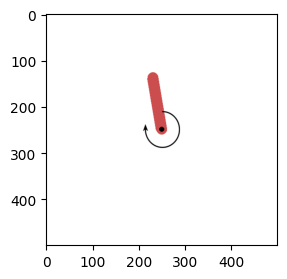

183.86113106128212

In [8]:
play(True)[-1]